This notebook aims to check the GLD360 dataset which is saved as Coordinate Format (COO).

Reference of COO:

- [Sparse Matrices](https://matteding.github.io/2019/04/25/sparse-matrices/)

<img src="./imgs/coo.gif" width="700">

Because the COO format is not intuitive, we decide to convert into csv file.

In [1]:
import pandas as pd
import numpy as np
import proplot as pplt
from pathlib import Path
from matplotlib.colors import LogNorm

pplt.rc.update({'meta.width': 0.6, 'label.weight': 'bold', 'tick.labelweight': 'normal'})


In [2]:
def read_section(df):
    """Read the sections"""
    # get the index of each section
    idx_meta = df.index[df[0] == 'METADATA'][0]
    idx_dimension = df.index[df[0] == 'DIMENSIONS'][0]
    idx_fields = df.index[df[0] == 'FIELDS'][0]
    idx_data = df.index[df[0] == 'DATA-SPARSE'][0]

    # read the data (meta_data, dimensions, fields, data) between sections
    meta_data = df.loc[idx_meta+1:idx_dimension-1]
    dimensions = df.loc[idx_dimension+1:idx_fields-1]
    dimensions.columns = ['dimensions']
    fields = df.loc[idx_fields+1:idx_data-1]
    fields.columns = ['fields']
    data = df.loc[idx_data+1:]
    data.columns = ['data']

    return dimensions, fields, data

In [3]:
def read_dim(dimensions, varname):
    """Read the dimension info"""
    # get the data and delete the varname
    #   start_value, end_value, number of bins
    var_list = dimensions[dimensions['dimensions'].str.startswith(varname)]['dimensions'].values[0].split(',')[1:]
    # convert into float type
    var_list = list(map(float, var_list))

    if varname != 'epochSeconds':
        # lon and lat
        return np.linspace(var_list[0], var_list[1], int(var_list[2])+1)
    else:
        # time
        st = var_list[0]
        dt = (var_list[1]-var_list[0])/var_list[2]
        return st, dt

In [4]:
def sparse_to_human(df):
    """convert the sparse data into human-readable data"""
    # copy the bin index for group bins later
    df['latitude_index'] = df['latitude']
    df['longitude_index'] = df['longitude']
    # convert into lon and lat
    df['latitude'] = df['latitude'].apply(lambda x: lat[int(x)])
    df['longitude'] = df['longitude'].apply(lambda x: lon[int(x)])
    # convert into datetime
    df['timestamp'] = pd.to_datetime(df['epochSeconds'].apply(lambda x: st+dt*int(x)), unit='s')

    # clean DataFrame
    df.drop(columns='epochSeconds', inplace=True)
    df.set_index('timestamp', inplace=True)
    df.sort_index(inplace=True)
    df = df.astype({'eventCount': int, 'latitude_index': int, 'longitude_index': int})

    return df

In [5]:
filename = '../data/gld360/gld-stroke-count-m0p1.asc'
df = pd.read_csv(filename, sep="\n", header=None)

# read sections
dimensions, fields, data = read_section(df)

# read dim infos
lat = read_dim(dimensions, 'latitude')
lon = read_dim(dimensions, 'longitude')
st, dt = read_dim(dimensions, 'epochSeconds')

# get the column names: dimensions + fields
data_columns = list(dimensions['dimensions'].str.split(',').str[0]) + list(fields['fields'])

# split the data column and save
data[data_columns] = data['data'].str.split(',',expand=True)

# drop the useless data and reset the index
df = sparse_to_human(data.drop(columns='data').reset_index(drop=True))

/home/xin/miniconda3/lib/python3.9/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


## Time series of 10-Min counts

In [6]:
def plot_minute(df, ax):
    """Plot the time series of 10-min counts"""
    count_60_10min = df[(df['latitude'] >= 60)]['eventCount'].resample('10Min').sum()
    count_70_10min = df[(df['latitude'] >= 70)]['eventCount'].resample('10Min').sum()
    count_80_10min = df[(df['latitude'] >= 80)]['eventCount'].resample('10Min').sum()

    l1 = ax.plot(count_60_10min.index, count_60_10min, c='blue7', label='> 60$^{\circ}$N')
    l2 = ax.plot(count_70_10min.index, count_70_10min, c='lime7', label='> 70$^{\circ}$N')
    l3 = ax.plot(count_80_10min.index, count_80_10min, c='red7', label='> 80$^{\circ}$N')

    ax.legend([l1, l2, l3], loc='ul')

    ax.format(xlabel='Date', ylabel='Events / 10 min',
              xlocator=('month', range(1, 12, 4)), xrotation=0,
              xminorlocator='month',
              yscale='log', ymin=1, yformatter='log')

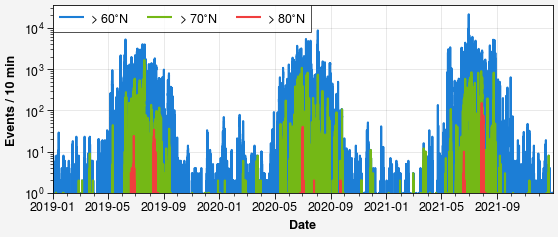

In [7]:
fig, axs = pplt.subplots(aspect=(8,3), axwidth=5)

plot_minute(df, axs)

## Geolocation distribution

In [8]:
# group data by lon/lat bins
df_geo_sum = df.groupby(['longitude_index', 'latitude_index'])['eventCount'].sum().reset_index()

# create a 2D array filled with nan
count_geo_sum = np.full((len(lon), len(lat)), np.nan)

# fill data by bin indexes
count_geo_sum[df_geo_sum['longitude_index'], df_geo_sum['latitude_index']] = df_geo_sum['eventCount']

In [9]:
def plot_geo_sum(lon, lat, count_geo_sum, ax):
    """Plot the geo distribution of summed count"""
    lats, lons = np.meshgrid(lat, lon)
    m = ax.pcolormesh(lons, lats, count_geo_sum, cmap='Ice_r',
                      norm=LogNorm(), discrete=False)
    ax.colorbar([m], loc='r')

    ax.format(coast=True, reso='med',
            latlines=10, gridcolor='black', gridlinewidth=2, gridlinestyle='--', latinline=True,
            lonlabels='lrbt',
            boundinglat=60,
            title='Arctic Events \n (2019-01-01 ~ 2022-01-01)',
            facecolor='Gray'
            )

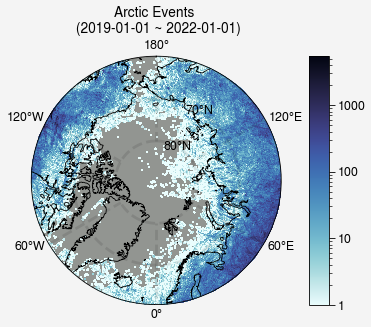

In [10]:
fig, axs = pplt.subplots(proj='npstere')

plot_geo_sum(lon, lat, count_geo_sum, axs)

## Summary

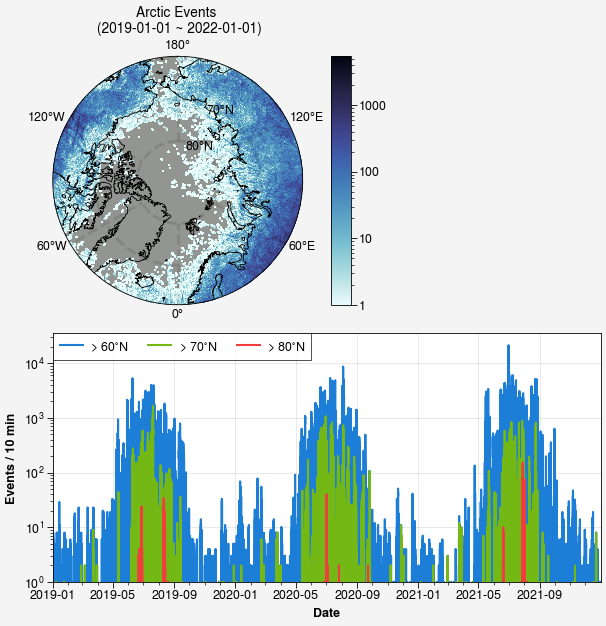

In [11]:
gs = pplt.GridSpec(nrows=2, ncols=2, pad=1)

fig = pplt.figure(span=False)

ax = fig.subplot(gs[0, 0], proj='npstere')
plot_geo_sum(lon, lat, count_geo_sum, ax)

ax = fig.subplot(gs[1, :])
plot_minute(df, ax)

It's better to add the summer NO2 distribution beside the arctic event subplot.

## Export data into daily input for S5P-LNO2

In [12]:
# for name, group in df.groupby(df.index.date):
#     save_dir = f"../data/gld360/density/{name.strftime('%Y%m')}/"
#     save_name = f"{name.strftime('%Y%m%d.csv')}"
#     Path(save_dir).mkdir(parents=True, exist_ok=True)
#     group[['longitude','latitude','eventCount']].to_csv(save_dir+save_name, float_format='%.1f', index=False)

## Check the special case which occured over 80 N

In [17]:
df_high = df['2019-08-10 16:00':'2019-08-11 01:00']
df_high = df_high[df_high['latitude']>80]
# df_high = df['2019-07-10 16:00':'2019-07-11 02:00']
# df_high = df_high[df_high['latitude']>65]

In [18]:
df_high

,latitude,longitude,eventCount,latitude_index,longitude_index
timestamp,,,,,
2019-08-10 17:50:00,83.8,110.7,1,238,2907
2019-08-10 17:50:00,83.9,110.7,1,239,2907
2019-08-10 17:50:00,83.9,110.6,2,239,2906
2019-08-10 17:50:00,83.4,108.1,2,234,2881
2019-08-10 18:00:00,83.9,111.4,1,239,2914
...,...,...,...,...,...
2019-08-11 00:50:00,84.7,127.6,1,247,3076
2019-08-11 01:00:00,84.7,127.3,1,247,3073
2019-08-11 01:00:00,84.7,127.4,1,247,3074


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

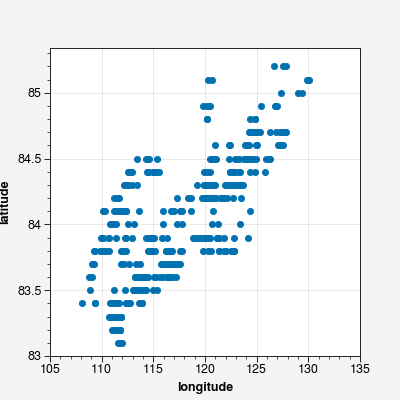

In [20]:
df_high.plot.scatter(x='longitude', y='latitude', xlim=(105, 135), ylim=(83, None))